In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
company = 'Reliance'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [ ]:
# Load the CSV file with date parsing and setting 'Date' as the index
stock_data = pd.read_csv("/content/drive/MyDrive/MTP/ITC_modified.csv", parse_dates=['Date'], sep=',', index_col='Date')
stock_data.tail()

,Open,High,Low,Close,VWAP,Volume,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
Date,,,,,,,,,,,,
2023-10-20,449.55,449.55,437.30,438.25,440.329224,707774,19556,311653576,169505.0,23.95,12.25,-11.30
2023-10-23,438.45,439.85,433.10,435.85,436.465065,256545,6596,111972930,121265.0,47.27,6.75,-2.60
2023-10-25,436.05,437.80,427.15,432.60,432.687493,237556,6834,102787510,105398.0,44.37,10.65,-3.45
2023-10-26,429.95,436.50,429.90,434.10,432.462342,386413,6954,167109071,94918.0,24.56,6.60,4.15
2023-10-27,435.90,436.80,432.20,433.50,433.916551,535910,12354,232540219,83785.0,15.63,4.60,-2.40


# Plotting UBER stock closing prices

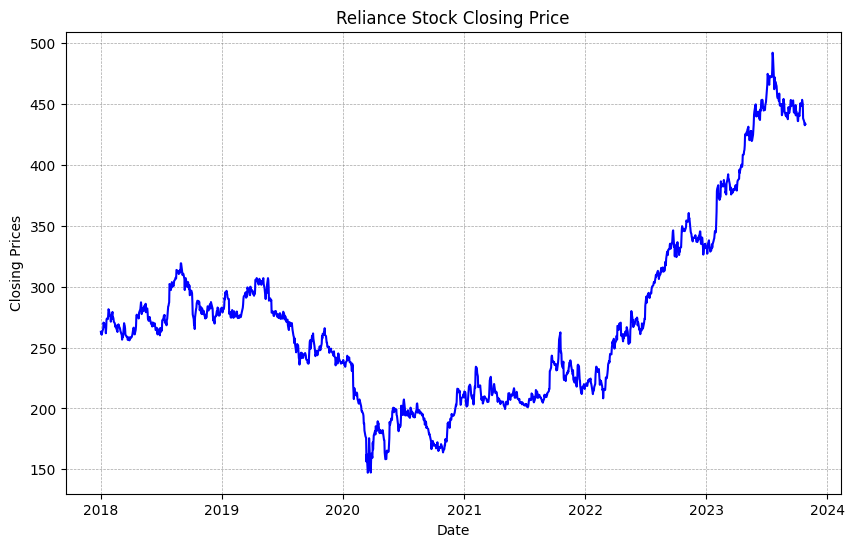

In [ ]:
# Extract the 'Close' column for plotting
df_close = stock_data['Close']

# Set the default style, which includes a white background
plt.style.use('default')

# Plot configuration
plt.figure(figsize=(10, 6))
plt.plot(df_close, color='blue')  # Optionally, set a line color

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Reliance Stock Closing Price')

# Show grid if desired
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.show()


In [ ]:

def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    # Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Set plot style to default for white background
    plt.style.use('default')  # or plt.style.use('seaborn-white')

    # Plot the original time series and rolling statistics
    plt.figure(figsize=(10, 6))  # Optional: specify figure size
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of Reliance Stock')
    plt.grid()  # Optional: Add grid for better readability
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


<Figure size 1000x600 with 0 Axes>

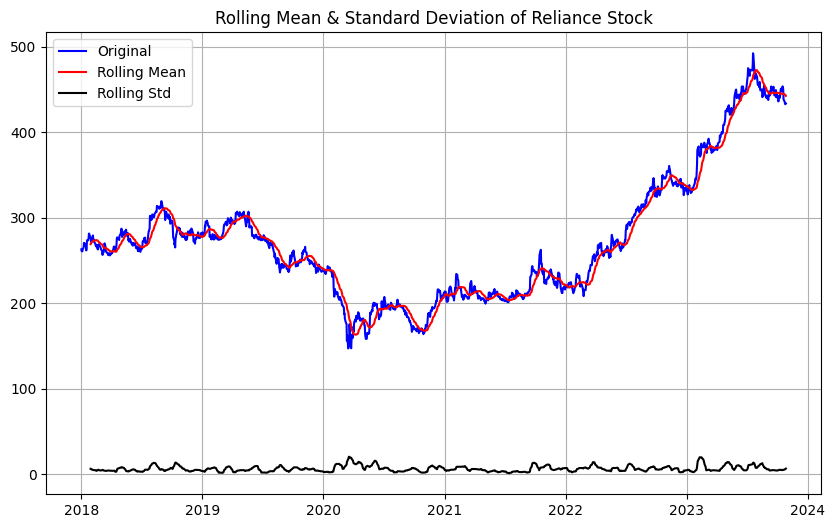

Results of Dickey-Fuller Test:
Test Statistic                    0.166538
p-value                           0.970321
#Lags Used                        0.000000
Number of Observations Used    1441.000000
Critical Value (1%)              -3.434896
Critical Value (5%)              -2.863548
Critical Value (10%)             -2.567839
dtype: float64


In [ ]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

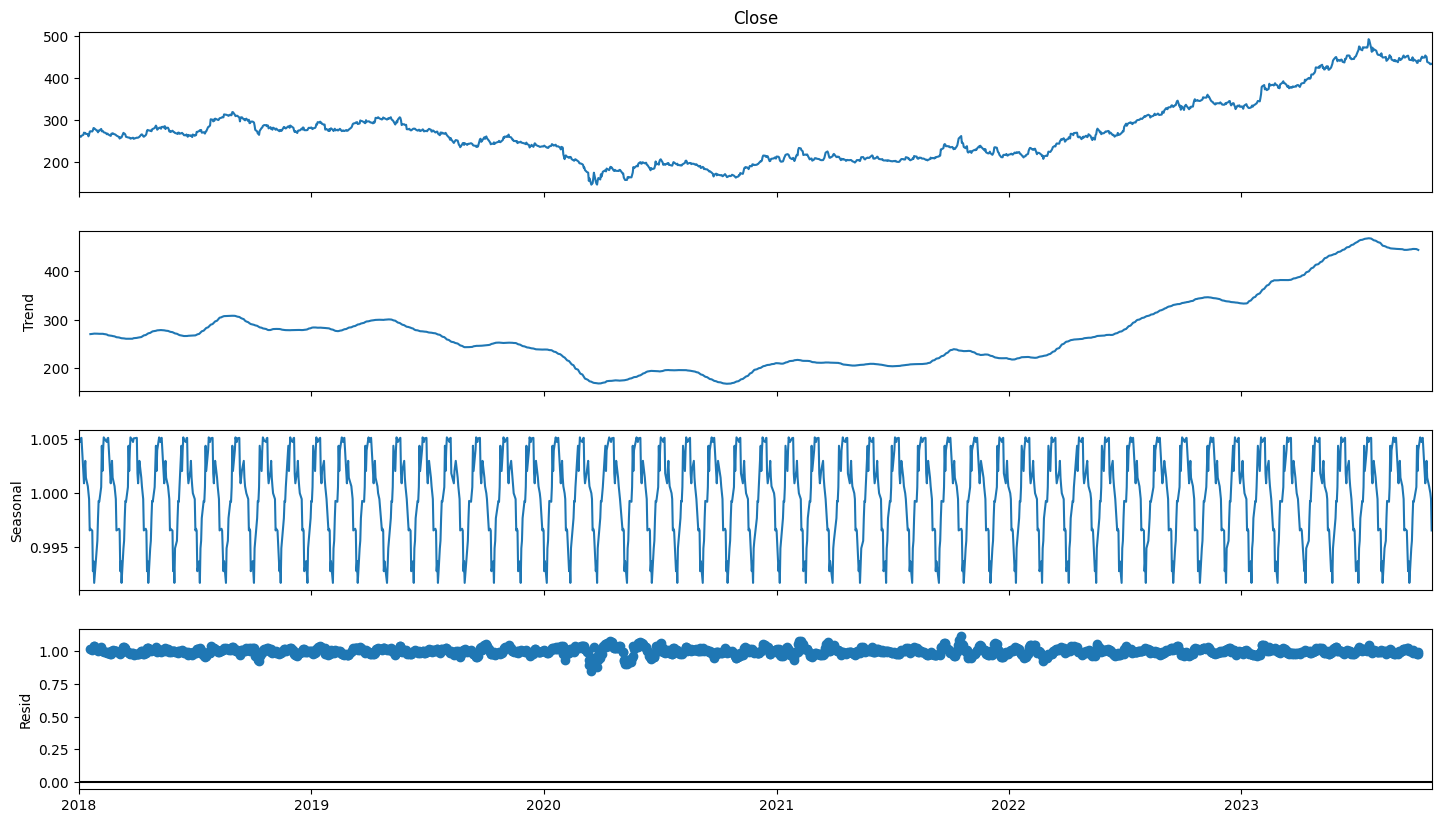

In [ ]:
plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

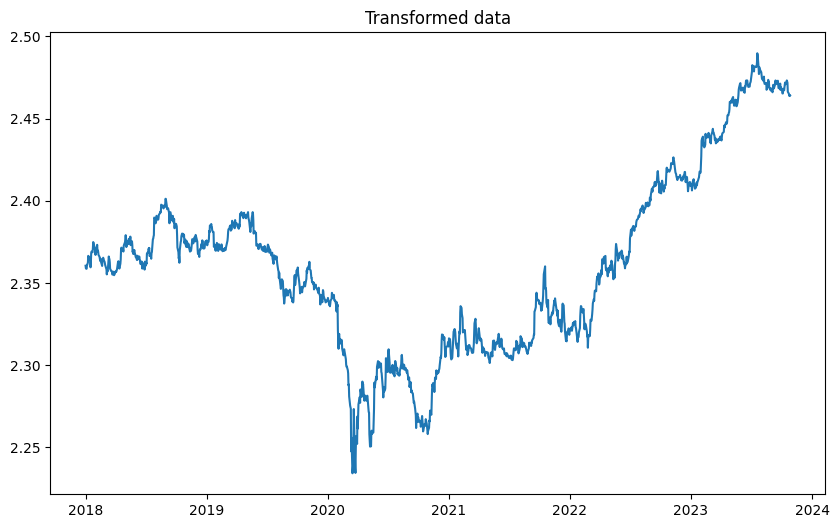

In [ ]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

<Figure size 1000x600 with 0 Axes>

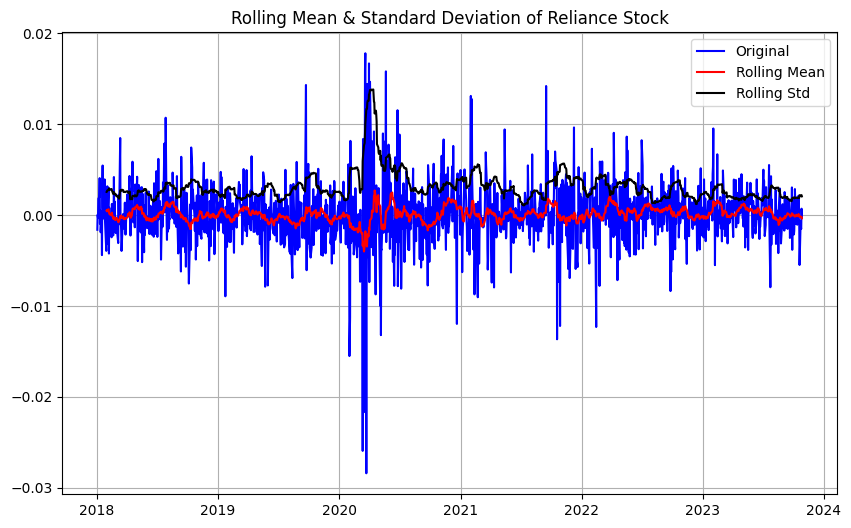

Results of Dickey-Fuller Test:
Test Statistic                -1.117306e+01
p-value                        2.611294e-20
#Lags Used                     1.200000e+01
Number of Observations Used    1.428000e+03
Critical Value (1%)           -3.434938e+00
Critical Value (5%)           -2.863566e+00
Critical Value (10%)          -2.567849e+00
dtype: float64


In [ ]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [ ]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

# Selecting prediction timeframe in days.

In [ ]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

# Divide the dataset into training and test sets

In [ ]:

test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

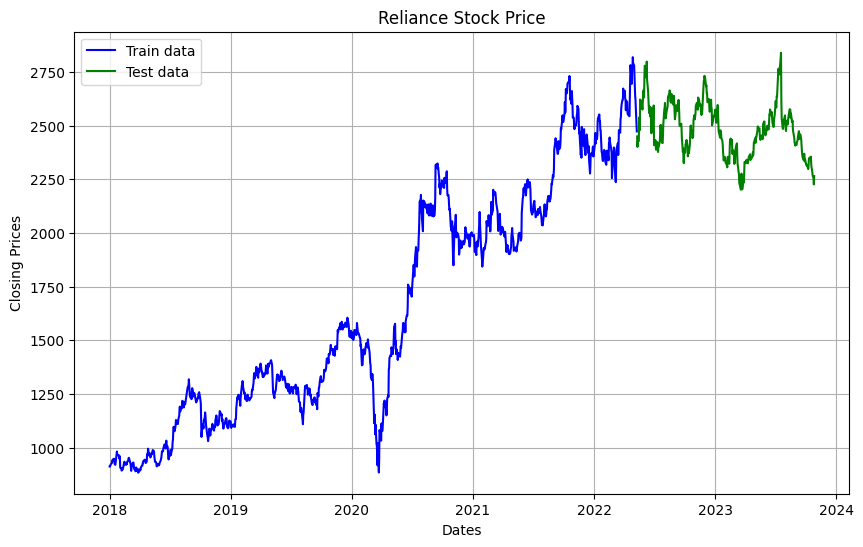

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.title(company + ' Stock Price')

plt.legend()

In [ ]:
!pip install tensorflow

In [ ]:

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

def vanilla_LSTM():
    """
    Defines a simple vanilla LSTM model.
    """
    model = Sequential()
    # Use keras.layers.LSTM to ensure the correct layer type is used.
    model.add(keras.layers.LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model


In [ ]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 3.5592e-05 - mean_absolute_error: 0.0046
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.5933e-05 - mean_absolute_error: 0.0028
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.5236e-05 - mean_absolute_error: 0.0028
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.4554e-05 - mean_absolute_error: 0.0027
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.4714e-05 - mean_absolute_error: 0.0027
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.5480e-05 - mean_absolute_error: 0.0027
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.3939e-05 - mean_absolute_error: 0.0026
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.5279e-05 - mean_absolute_error: 0.0028
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 1.5415e-05 - mean_absolute_error: 0.0028
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 1.5149e-05 - mean_absolute_error: 0.0027

# Evaluating the model using test data

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0024e-05 - mean_absolute_error: 0.0024
Test MSE: 8.060750587901566e-06
Test MAE: 0.002157576149329543


# Prediction Analysis

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


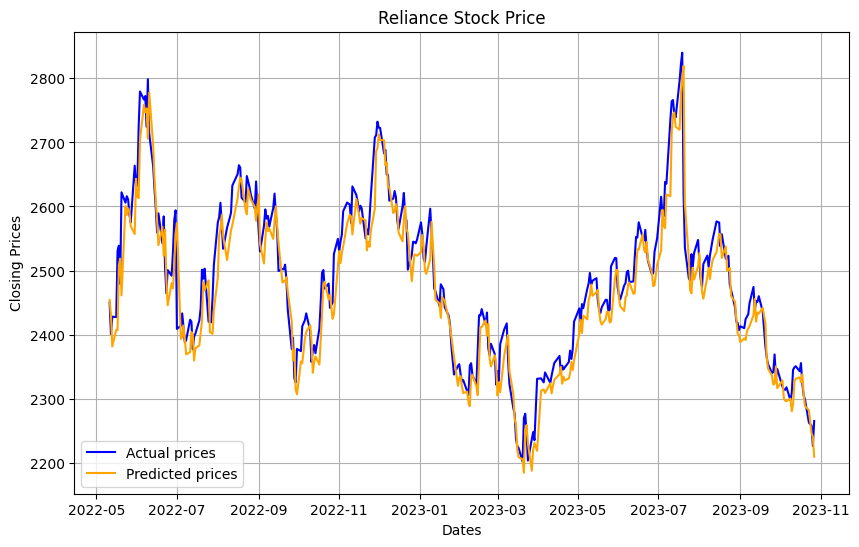

In [ ]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

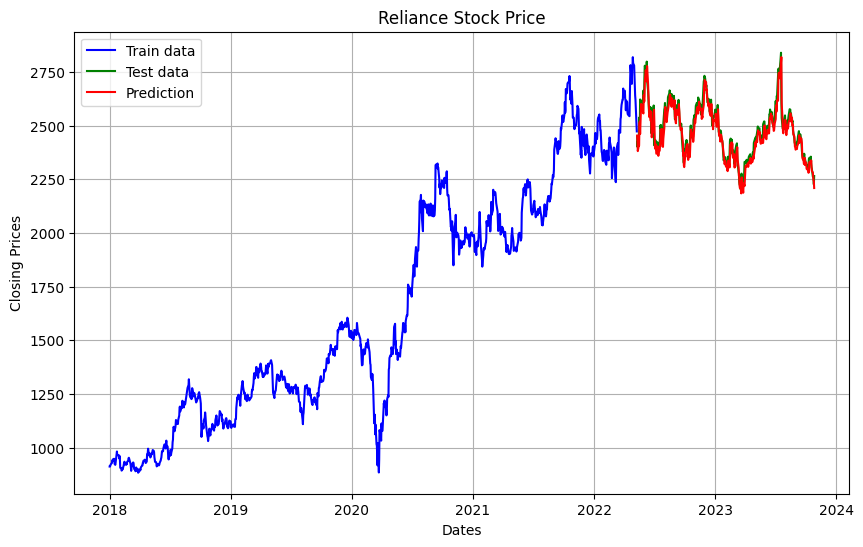

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'red', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [ ]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

# Time horizon for future prediction compared to the historical basis

In [ ]:
n_steps_out = 10

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)


# Split the data set between the training set and the test set

In [ ]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [ ]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [ ]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.9959e-05 - mean_absolute_error: 0.0032
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.5497e-05 - mean_absolute_error: 0.0027
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6311e-05 - mean_absolute_error: 0.0028
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5191e-05 - mean_absolute_error: 0.0027
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4653e-05 - mean_absolute_error: 0.0027
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4982e-05 - mean_absolute_error: 0.0027
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4753e-05 - mean_absolute_error: 0.0027
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4855e-05 - mean_absolute_error: 0.0027
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5556e-05 - mean_absolute_error: 0.0027
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7239e-05 - mean_absolute_error: 0.0029

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0849e-06 - mean_absolute_error: 0.0022
Test MSE: 7.0340420279535465e-06
Test MAE: 0.0019330421928316355


In [ ]:
len(X_test)

365

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

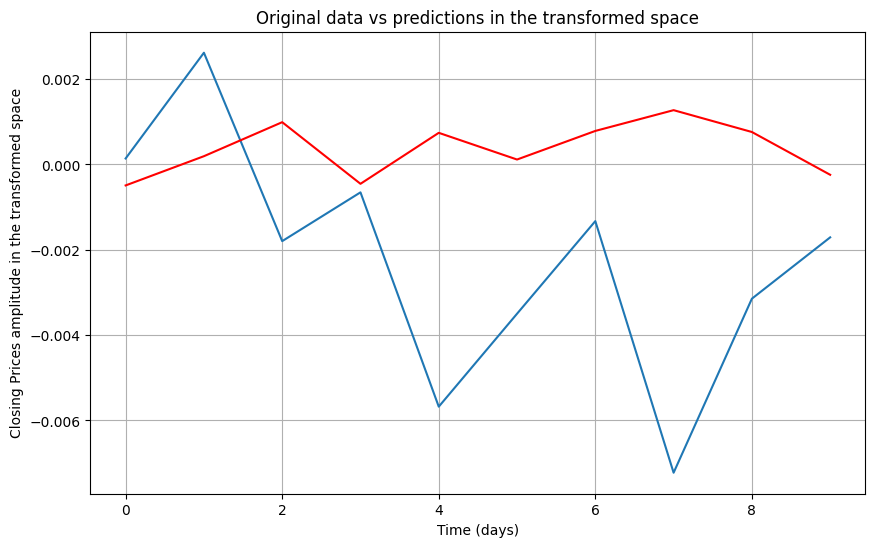

In [ ]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [ ]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2022-05-11    2.802498
2022-05-12    2.802691
2022-05-13    2.803683
2022-05-16    2.803230
2022-05-17    2.803971
2022-05-18    2.804087
2022-05-19    2.804874
2022-05-20    2.806147
2022-05-23    2.806908
2022-05-24    2.806666
dtype: float64


In [ ]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2022-05-11    2575.998753
2022-05-12    2578.800400
2022-05-13    2593.170505
2022-05-16    2586.591584
2022-05-17    2597.372862
2022-05-18    2599.063200
2022-05-19    2610.550306
2022-05-20    2629.263044
2022-05-23    2640.519139
2022-05-24    2636.939632
dtype: float64


# Plotting actual prices vs predicted prices

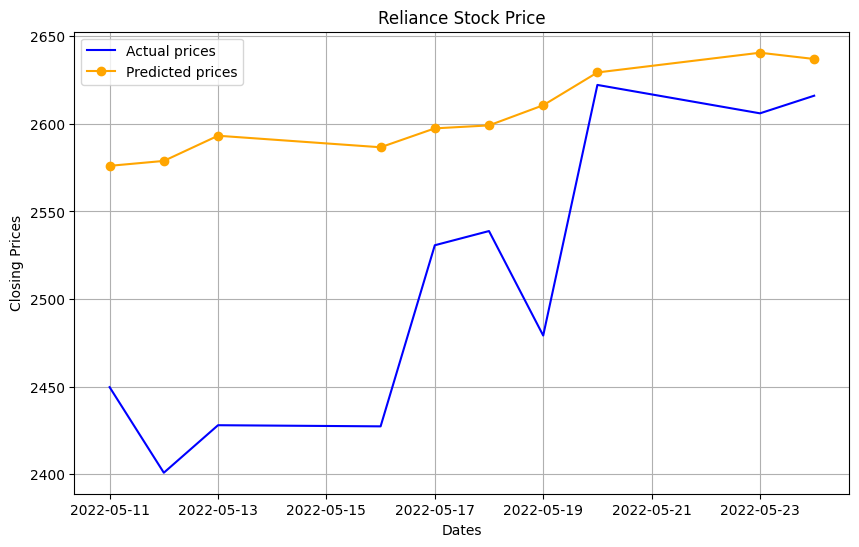

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv", parse_dates=['Date'], sep=',', index_col='Date')


In [ ]:
df_10 = pd.DataFrame()
df_10['Close'] = df['Close'].rolling(window=10).mean()
df_20 = pd.DataFrame()
df_20['Close'] = df['Close'].rolling(window=20).mean()
df_30 = pd.DataFrame()
df_30['Close'] = df['Close'].rolling(window=30).mean()
df_40 = pd.DataFrame()
df_40['Close'] = df['Close'].rolling(window=40).mean()

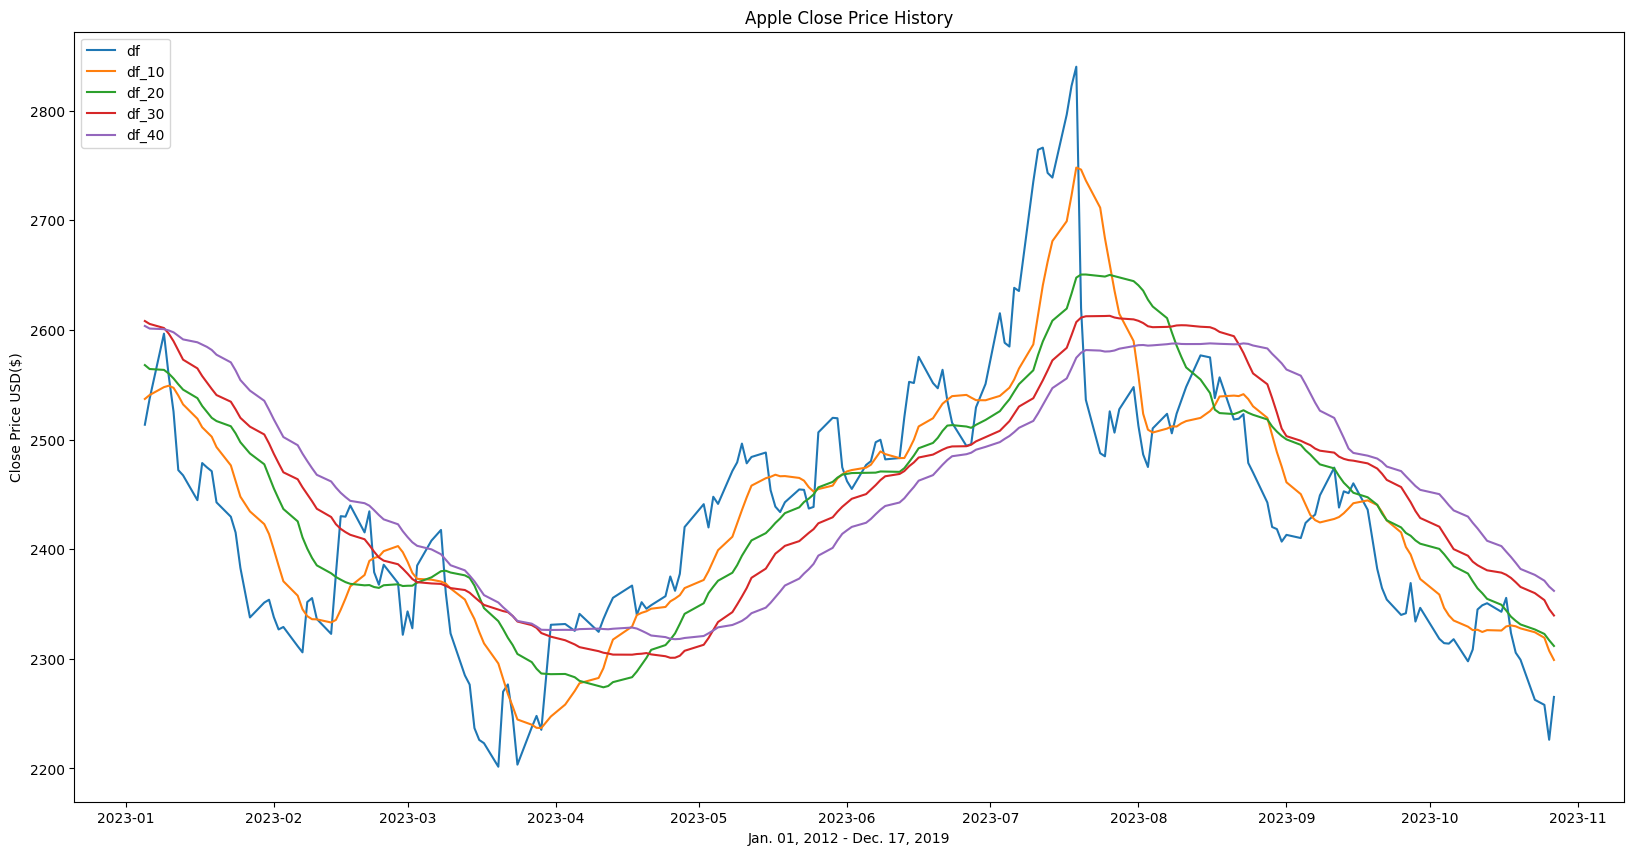

In [ ]:
#Visualize the data
plt.figure(figsize=(20,10))
plt.plot(df['Close'].tail(200), label='df')
plt.plot(df_10['Close'].tail(200), label='df_10')
plt.plot(df_20['Close'].tail(200), label='df_20')
plt.plot(df_30['Close'].tail(200), label='df_30')
plt.plot(df_40['Close'].tail(200), label='df_40')
plt.title('Apple Close Price History')
plt.xlabel('Jan. 01, 2012 - Dec. 17, 2019')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
ma50 = df.Close.rolling(50).mean()
ma50.head()

,Close
Date,
2018-01-01,NaN
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN


In [ ]:
ma100 = df.Close.rolling(100).mean()
ma100

,Close
Date,
2018-01-01,NaN
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN
...,...
2023-10-20,2490.2285
2023-10-23,2487.6610
2023-10-25,2485.4940


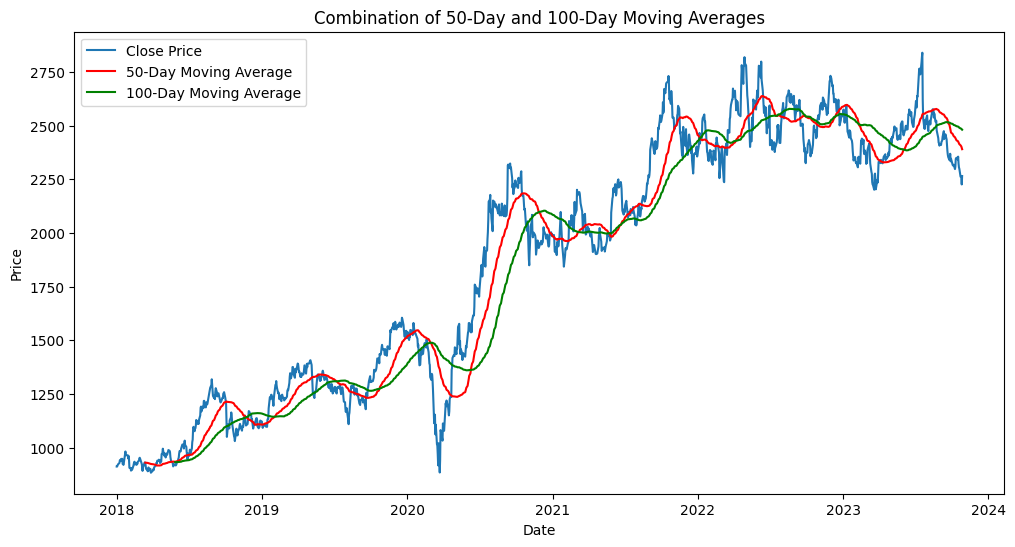

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(ma50, 'r', label='50-Day Moving Average')
plt.plot(ma100, 'g', label='100-Day Moving Average')
plt.title('Combination of 50-Day and 100-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


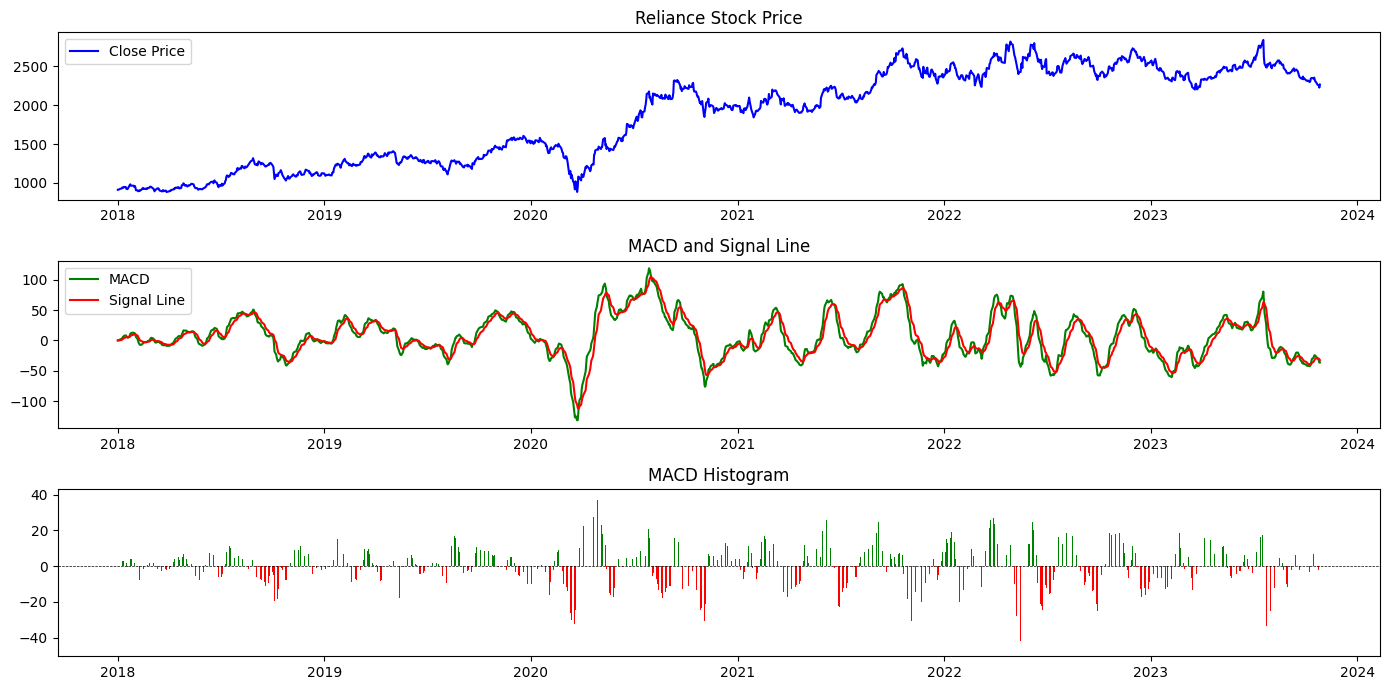

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate MACD and Signal line
def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=9, adjust=False).mean()

    # Add MACD and Signal line to the DataFrame
    df['MACD'] = macd
    df['Signal Line'] = signal_line
    df['Histogram'] = macd - signal_line  # Calculate Histogram
    return df

# Example DataFrame (make sure to replace this with your actual DataFrame)
# df = pd.read_csv("your_stock_data.csv", parse_dates=['date'], index_col='date')

# Call the function to calculate MACD
df_with_macd = calculate_macd(df)

# Plotting the MACD, Signal Line, and Histogram
plt.figure(figsize=(14, 7))

# Plot the closing price
plt.subplot(3, 1, 1)
plt.plot(df_with_macd['Close'], label='Close Price', color='blue')
plt.title('Reliance Stock Price')
plt.legend()

# Plot the MACD and Signal Line
plt.subplot(3, 1, 2)
plt.plot(df_with_macd['MACD'], label='MACD', color='green')
plt.plot(df_with_macd['Signal Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.legend()

# Plot the Histogram
plt.subplot(3, 1, 3)
plt.bar(df_with_macd.index, df_with_macd['Histogram'], color=['green' if x >= 0 else 'red' for x in df_with_macd['Histogram']], width=0.5)
plt.title('MACD Histogram')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a line at y=0 for reference
plt.tight_layout()

# Show the plots
plt.show()


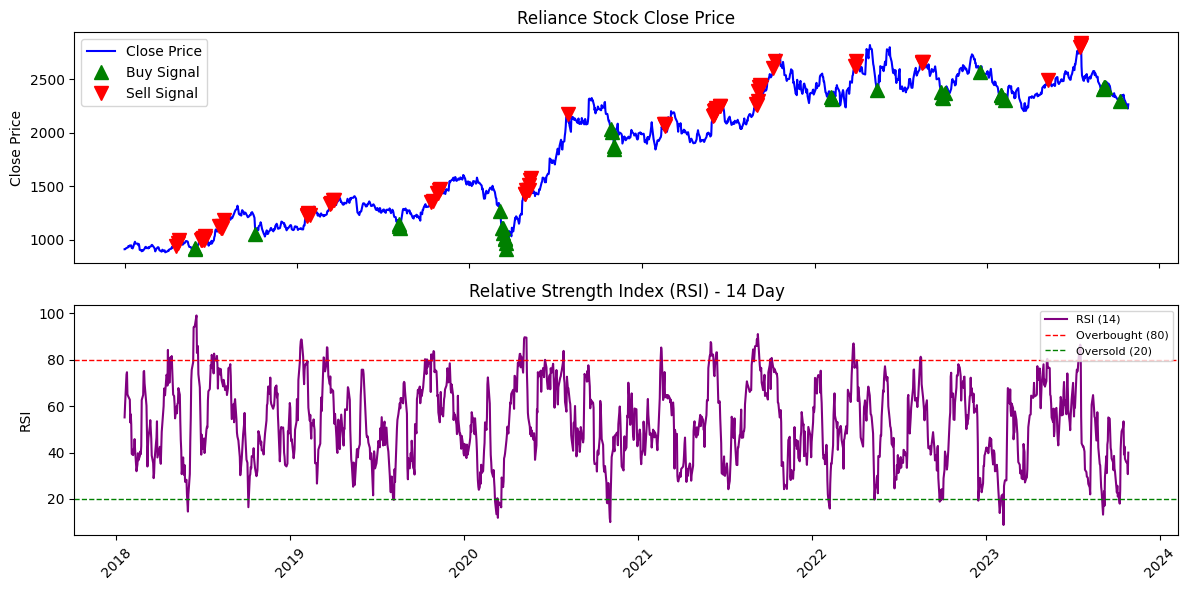

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df= pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is the DataFrame with 'Date' and 'Close' columns
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 1: Calculate the RSI
window_length = 14

# Calculate price differences
delta = df['Close'].diff()

# Separate positive and negative gains
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()

# Calculate the Relative Strength (RS) and RSI
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Step 2: Identify Buy and Sell signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20
sell_signals = (RSI > 80)  # Sell when RSI is above 80

# Step 3: Plot the close price and RSI with buy/sell signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

# Set yellow background for both subplots
# fig.patch.set_facecolor('yellow')

# Plot the Close Price in the first subplot
ax1.plot(df['Date'], df['Close'], color='blue', label='Close Price')
ax1.set_title('Reliance Stock Close Price')
ax1.set_ylabel('Close Price')
ax1.grid(True, color='white')  # Grid lines in white for contrast

# Plot Buy and Sell signals
ax1.plot(df['Date'][buy_signals], df['Close'][buy_signals],
         '^', markersize=10, color='green', label='Buy Signal')  # Buy signal in green
ax1.plot(df['Date'][sell_signals], df['Close'][sell_signals],
         'v', markersize=10, color='red', label='Sell Signal')  # Sell signal in red

# Plot the RSI in the second subplot
ax2.plot(df['Date'], RSI, color='purple', label='RSI (14)')  # RSI in cyan
ax2.set_title('Relative Strength Index (RSI) - 14 Day')
ax2.set_ylabel('RSI')
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought (80)')  # Overbought line in red
ax2.axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold (20)')  # Oversold line in green
ax2.grid(True, color='white')  # Grid lines in white for contrast

# Format x-axis to show only the year labels on the bottom subplot
ax2.xaxis.set_major_locator(mdates.YearLocator())  # Show ticks at the start of each year
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.setp(ax2.get_xticklabels(), rotation=45)  # Rotate for readability

# Ensure date labels are only on the bottom subplot
ax1.tick_params(axis='x', labelbottom=False)

# Custom legend for signals on the right corner
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', fontsize=10)
handles_rsi, labels_rsi = ax2.get_legend_handles_labels()
ax2.legend(handles_rsi, labels_rsi, loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


Portfolio Buy Signal Details:
Date: 2018-05-30, Price: 917.35, Amount Invested: 917.35, Total Invested: 917.35, Total Shares: 1
Date: 2018-05-31, Price: 921.30, Amount Invested: 921.30, Total Invested: 1838.65, Total Shares: 2
Date: 2018-10-05, Price: 1049.85, Amount Invested: 1049.85, Total Invested: 2888.50, Total Shares: 3
Date: 2019-08-05, Price: 1143.00, Amount Invested: 1143.00, Total Invested: 4031.50, Total Shares: 4
Date: 2019-08-06, Price: 1128.00, Amount Invested: 1128.00, Total Invested: 5159.50, Total Shares: 5
Date: 2019-08-07, Price: 1109.00, Amount Invested: 1109.00, Total Invested: 6268.50, Total Shares: 6
Date: 2020-03-06, Price: 1270.05, Amount Invested: 1270.05, Total Invested: 7538.55, Total Shares: 7
Date: 2020-03-09, Price: 1113.15, Amount Invested: 1113.15, Total Invested: 8651.70, Total Shares: 8
Date: 2020-03-12, Price: 1061.60, Amount Invested: 1061.60, Total Invested: 9713.30, Total Shares: 9
Date: 2020-03-13, Price: 1106.90, Amount Invested: 1106.90, Total 

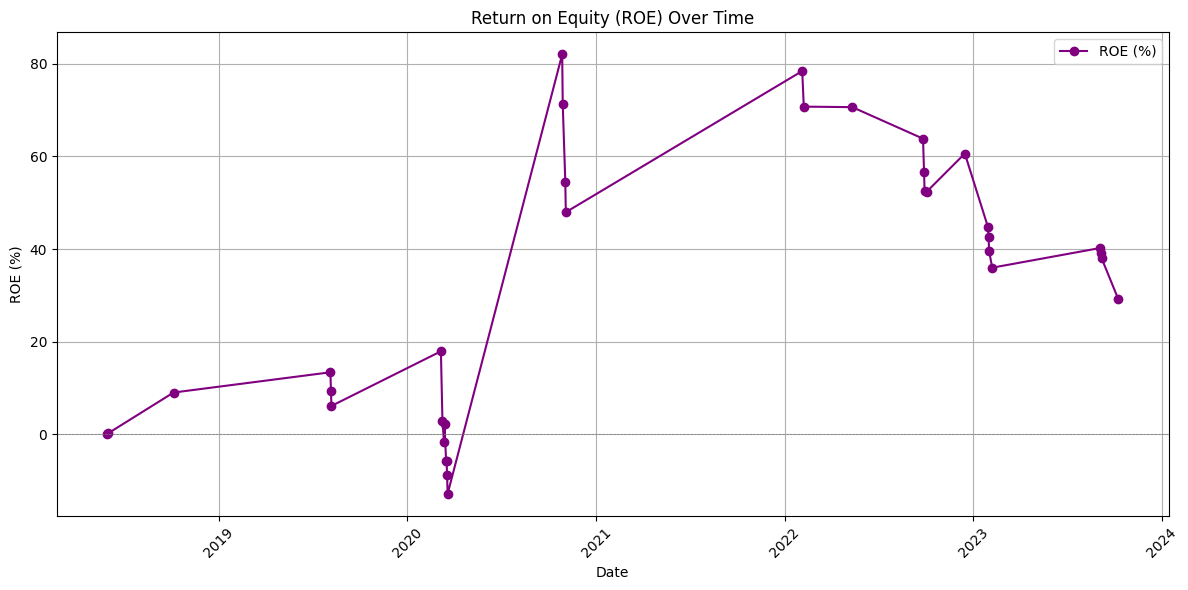

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the RSI
window_length = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Identify Buy signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20

# Variables to track investment over time
initial_investment = 1000
total_invested = 0
total_shares = 0  # Total shares accumulated
final_price = 0

# Variables to track signals and their details
portfolio_details = []
total_buy_signals = 0
roe_values = []  # To store ROE values over time
dates = []      # To store dates corresponding to ROE values

# Track investment over time
for i in range(len(df)):
    # Buy signal
    if buy_signals[i]:
        total_buy_signals += 1

        # Current price at the buy signal
        current_price = df['Close'][i]

        # Update the total shares and invested amount
        total_shares += 1  # Since we are buying one share at each signal
        total_invested += current_price  # Update total invested amount

        # Store portfolio details
        portfolio_details.append({
            'Date': df['Date'][i],
            'Price': current_price,
            'Amount Invested': current_price,
            'Total Invested': total_invested,
            'Total Shares': total_shares
        })

        # Calculate the current portfolio value
        current_portfolio_value = total_shares * df['Close'][i]
        # Calculate ROE
        roe = ((current_portfolio_value - total_invested) / total_invested) * 100 if total_invested > 0 else 0

        # Append the ROE and corresponding date
        roe_values.append(roe)
        dates.append(df['Date'][i])

# Calculate final price based on the last closing price in the DataFrame
if len(df) > 0:
    final_price = df['Close'].iloc[-1]  # Last price in the dataset
    final_portfolio_value = final_price * total_shares  # Total portfolio value at the end

# Print the portfolio details in chronological order
print("Portfolio Buy Signal Details:")
for detail in portfolio_details:
    print(f"Date: {detail['Date'].date()}, Price: {detail['Price']:.2f}, "
          f"Amount Invested: {detail['Amount Invested']:.2f}, "
          f"Total Invested: {detail['Total Invested']:.2f}, "
          f"Total Shares: {detail['Total Shares']}")

# Calculate and print the final portfolio value and ROE
roe_final = ((final_portfolio_value - total_invested) / total_invested) * 100 if total_invested > 0 else 0

print(f"\nFinal Portfolio Value: {final_portfolio_value:.2f}")
print(f"Total Amount Invested: {total_invested:.2f}")
print(f"Return on Equity (ROE): {roe_final:.2f}%")
print(f"Total Buy Signals: {total_buy_signals}")

# Plot ROE values over time
plt.figure(figsize=(12, 6))
plt.plot(dates, roe_values, marker='o', color='purple', label='ROE (%)')
plt.title('Return on Equity (ROE) Over Time')
plt.xlabel('Date')
plt.ylabel('ROE (%)')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add horizontal line at 0%
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


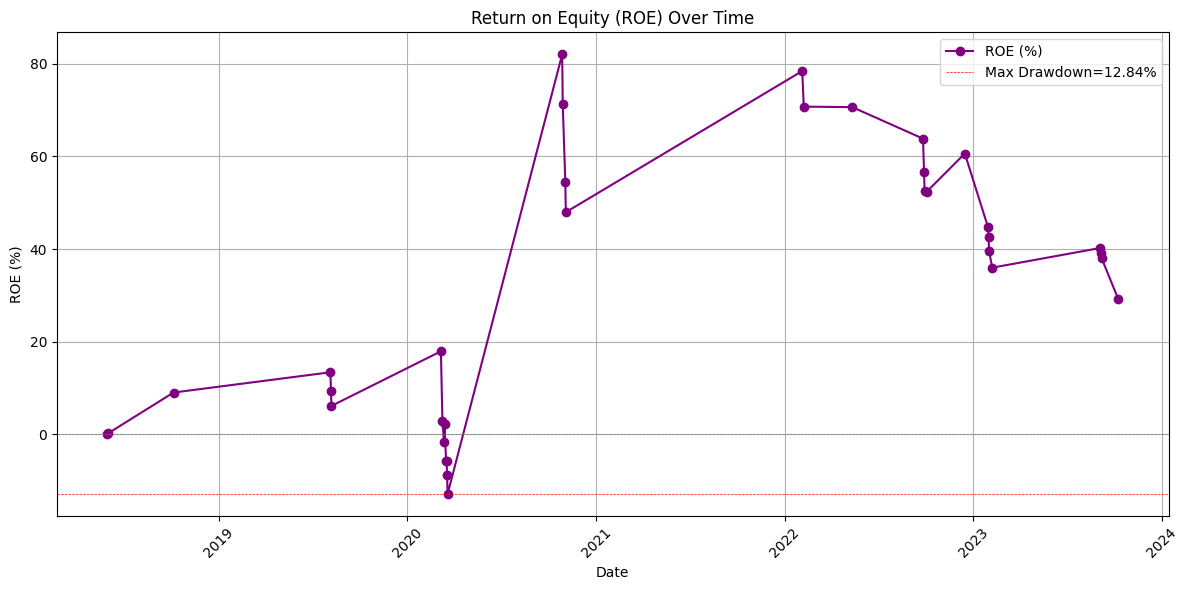

Maximum Drawdown: -12.84%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the RSI
window_length = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Identify Buy signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20

# Variables to track investment over time
total_invested = 0
total_shares = 0  # Total shares accumulated
roe_values = []  # To store ROE values over time
dates = []      # To store dates corresponding to ROE values

# Track investment over time
for i in range(len(df)):
    # Buy signal
    if buy_signals[i]:
        # Current price at the buy signal
        current_price = df['Close'][i]

        # Update the total shares and invested amount
        total_shares += 1  # Since we are buying one share at each signal
        total_invested += current_price  # Update total invested amount

        # Calculate the current portfolio value
        current_portfolio_value = total_shares * df['Close'][i]
        # Calculate ROE
        roe = ((current_portfolio_value - total_invested) / total_invested) * 100 if total_invested > 0 else 0

        # Append the ROE and corresponding date
        roe_values.append(roe)
        dates.append(df['Date'][i])

# Calculate maximum drawdown
max_drawdown = min(roe_values) if roe_values else 0

# Plot ROE values over time
plt.figure(figsize=(12, 6))
plt.plot(dates, roe_values, marker='o', color='purple', label='ROE (%)')
plt.title('Return on Equity (ROE) Over Time')
plt.xlabel('Date')
plt.ylabel('ROE (%)')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add horizontal line at 0%
plt.axhline(max_drawdown, color='red', linewidth=0.5, linestyle='--', label='Max Drawdown=12.84%')  # Max drawdown line
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2f}%")


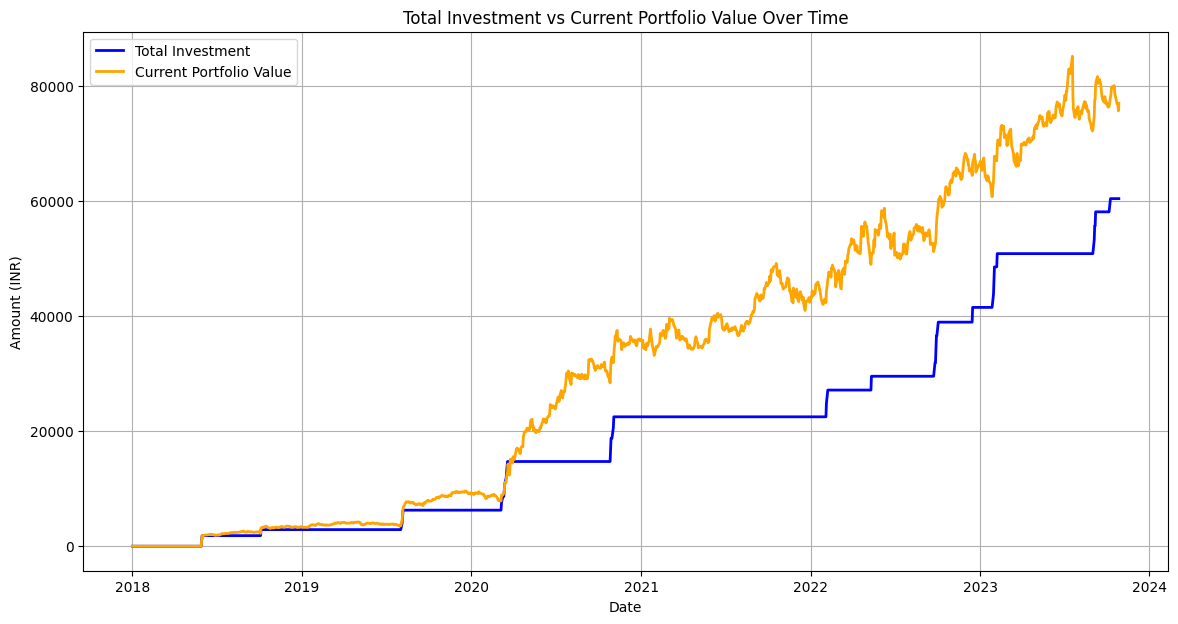

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame 'df' with 'Date' and 'Close' columns
# Ensure df is already defined with appropriate 'Date' and 'Close' data
# For example:
# df = pd.DataFrame({'Date': [...], 'Close': [...]})

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the RSI
window_length = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Identify Buy signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20

# Initialize variables
total_invested = 0
total_shares = 0
investment_series = []
value_series = []

# Loop through the DataFrame to calculate investment and portfolio value over time
for i in range(len(df)):
    # Update current investment and value
    current_price = df['Close'][i]
    if buy_signals[i]:
        total_shares += 1  # Buy one share
        total_invested += current_price  # Update total invested amount

    # Calculate the current portfolio value
    current_value = total_shares * current_price

    # Append to the series for plotting
    investment_series.append(total_invested)
    value_series.append(current_value)

# Create a DataFrame for plotting
df['Investment'] = investment_series
df['Portfolio_Value'] = value_series

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Investment'], label='Total Investment', color='blue', linewidth=2)
plt.plot(df['Date'], df['Portfolio_Value'], label='Current Portfolio Value', color='orange', linewidth=2)
plt.title('Total Investment vs Current Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Amount (INR)')
plt.legend()
plt.grid()
plt.show()


         Date  Investment Price  Total Investment  Current Portfolio Value  \
0  2018-01-31            961.15            961.15                   961.15   
1  2018-02-28            952.45           1913.60                  1904.90   
2  2018-04-30            963.10           2876.70                  2889.30   
3  2018-05-31            921.30           3798.00                  3685.20   
4  2018-07-31           1185.85           4983.85                  5929.25   
5  2018-08-31           1240.95           6224.80                  7445.70   
6  2018-10-31           1061.40           7286.20                  7429.80   
7  2018-11-30           1168.20           8454.40                  9345.60   
8  2018-12-31           1121.05           9575.45                 10089.45   
9  2019-01-31           1227.10          10802.55                 12271.00   
10 2019-02-28           1231.55          12034.10                 13547.05   
11 2019-04-30           1391.80          13425.90               

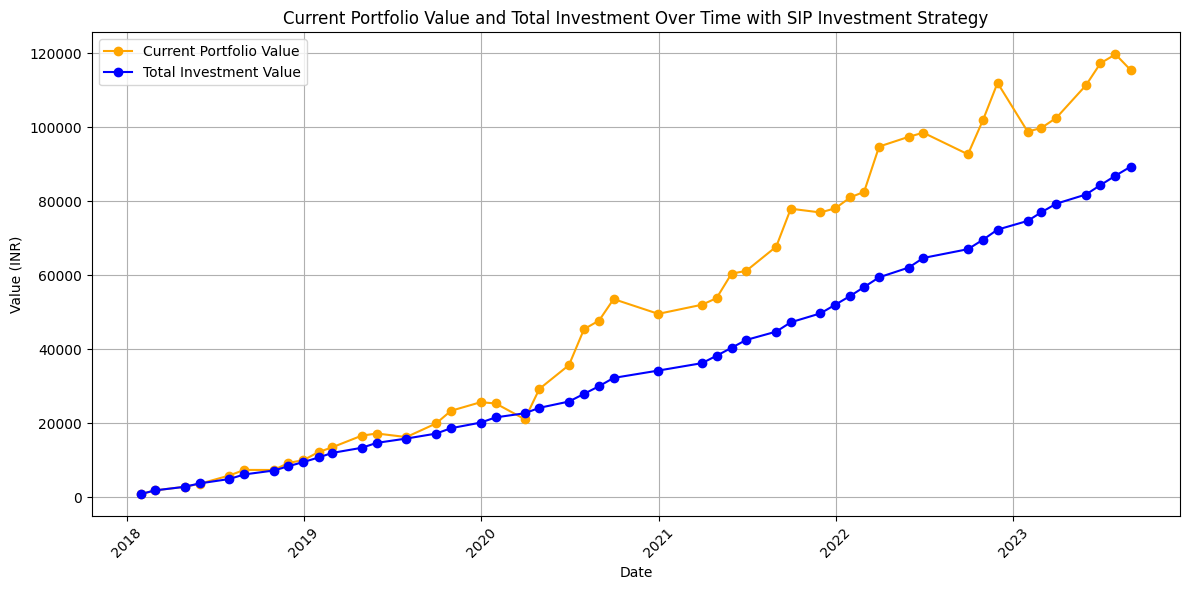

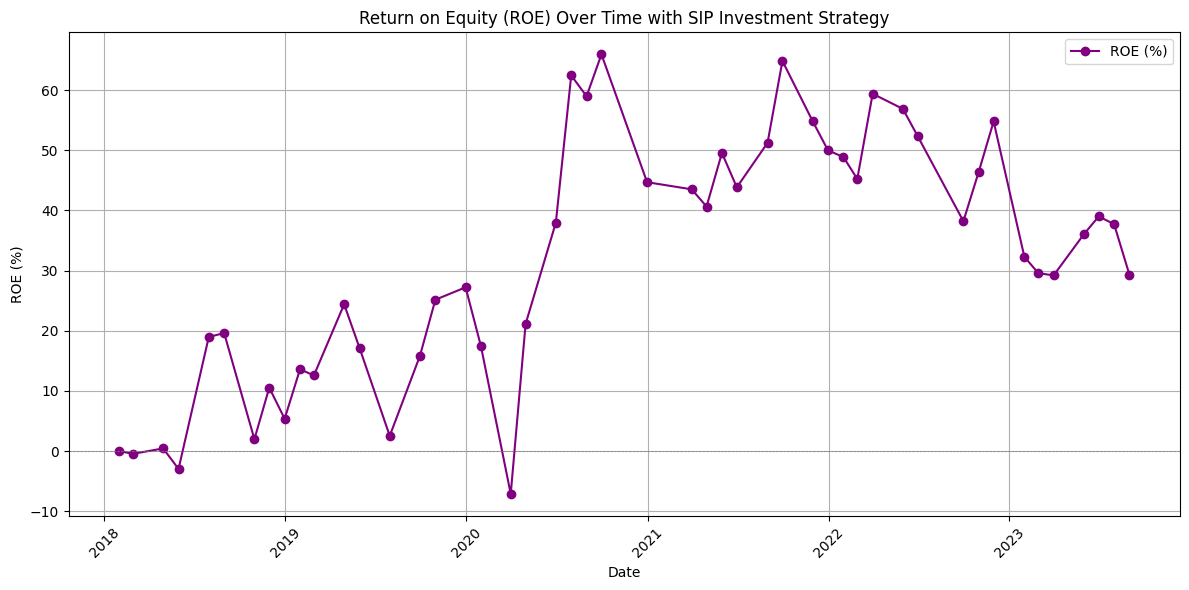

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date just in case
df = df.sort_values('Date')

# SIP Investment Strategy Variables
total_investment = 0     # Total investment
shares_owned = 0         # Total shares owned
investment_records = []  # To store each month's investment record

# Loop through the DataFrame to identify monthly investments
for index, row in df.iterrows():
    # Check if the row corresponds to the end of the month
    if row['Date'].is_month_end:  # This checks if the date is the last day of the month
        # Buy 1 share
        price = row['Close']
        shares_owned += 1
        total_investment += price  # Increase total investment by the price of the stock

        # Current portfolio value at this moment
        current_value = shares_owned * row['Close']  # Current value of the portfolio
        roe = (current_value - total_investment) / total_investment * 100  # ROE calculation

        # Record the investment details
        investment_records.append({
            'Date': row['Date'],
            'Investment Price': price,
            'Total Investment': total_investment,
            'Current Portfolio Value': current_value,
            'ROE (%)': roe
        })

# Convert records to DataFrame for better visualization
investment_df = pd.DataFrame(investment_records)

# Display the investment records
print(investment_df)

# Plotting the Current Portfolio Value and Total Investment
plt.figure(figsize=(12, 6))

# Plotting the Current Portfolio Value
plt.plot(investment_df['Date'], investment_df['Current Portfolio Value'], marker='o', label='Current Portfolio Value', color='orange')

# Plotting the Total Investment Value
plt.plot(investment_df['Date'], investment_df['Total Investment'], marker='o', label='Total Investment Value', color='blue')

plt.title('Current Portfolio Value and Total Investment Over Time with SIP Investment Strategy')
plt.xlabel('Date')
plt.ylabel('Value (INR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plotting ROE on a separate graph
plt.figure(figsize=(12, 6))
plt.plot(investment_df['Date'], investment_df['ROE (%)'], marker='o', color='purple', label='ROE (%)')

plt.title('Return on Equity (ROE) Over Time with SIP Investment Strategy')
plt.xlabel('Date')
plt.ylabel('ROE (%)')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add horizontal line at 0%
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


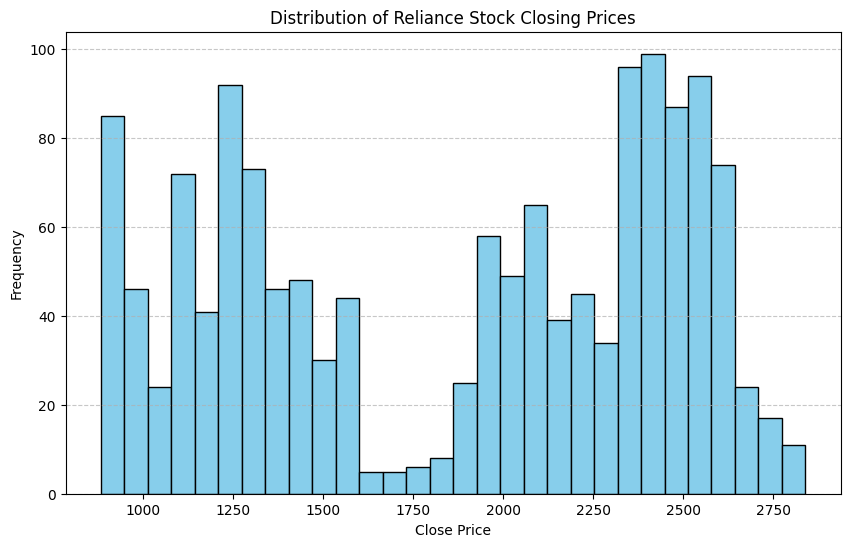

In [ ]:
import matplotlib.pyplot as plt

# Plotting histogram of the closing prices
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Reliance Stock Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


              Open    High     Low   Close        VWAP   Volume  \
Date                                                              
2018-01-01  922.00  923.00  909.70  911.55  916.271514   242669   
2018-01-02  915.00  919.20  907.25  911.40  915.460503  1763025   
2018-01-03  924.45  927.20  913.30  916.35  920.140625   515755   
2018-01-04  919.00  921.80  916.00  920.25  918.934284   238922   
2018-01-05  920.50  925.85  919.45  923.00  922.699680   406686   

            No. of Trades  Total Turnover (Rs.)  Deliverable Quantity  \
Date                                                                    
2018-01-01           4561          2.223507e+08                101598   
2018-01-02           4599          1.613980e+09                 83984   
2018-01-03           6497          4.745671e+08                218031   
2018-01-04           3185          2.195536e+08                111336   
2018-01-05           3944          3.752490e+08                140413   

            % Deli

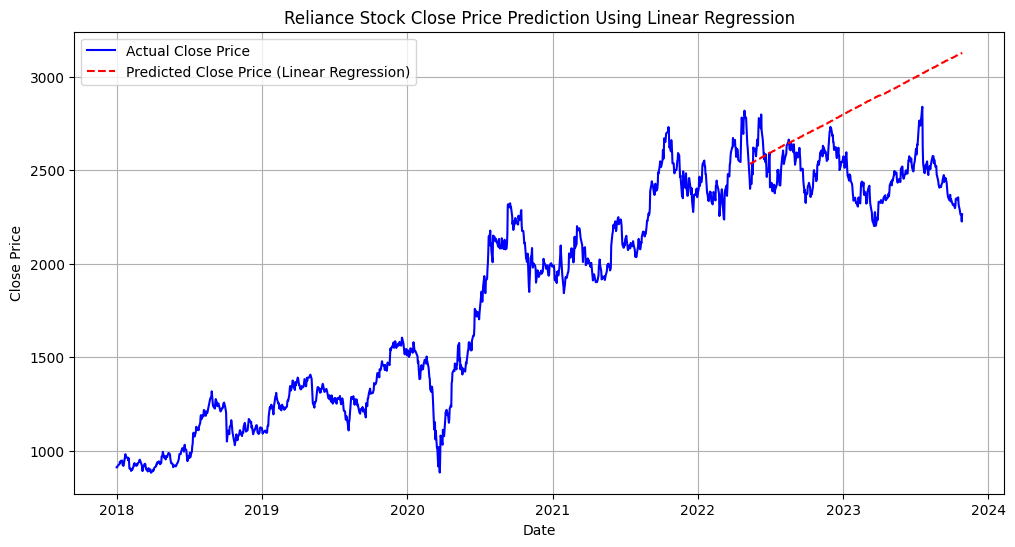

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv", parse_dates=['Date'], index_col='Date')

# Verify that 'Date' is in the index
print(df.head())  # Check the first few rows and column names

# Sort by the index (date) for time-series consistency
df = df.sort_index()

# Create a feature 'day' as a numeric representation of days to fit a time-based regression
df['day'] = np.arange(len(df))

# Separate features and target variable
X = df[['day']]
y = df['Close']

# Define the number of test days
test_days = 365

# Split the data into training and testing sets
X_train, X_test = X[:-test_days], X[-test_days:]
y_train, y_test = y[:-test_days], y[-test_days:]

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_reg = model.predict(X_test)

# Plot the actual closing prices and the prediction curve
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual Close Price', color='blue')
plt.plot(df.index[-test_days:], y_pred_reg, label='Predicted Close Price (Linear Regression)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Reliance Stock Close Price Prediction Using Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


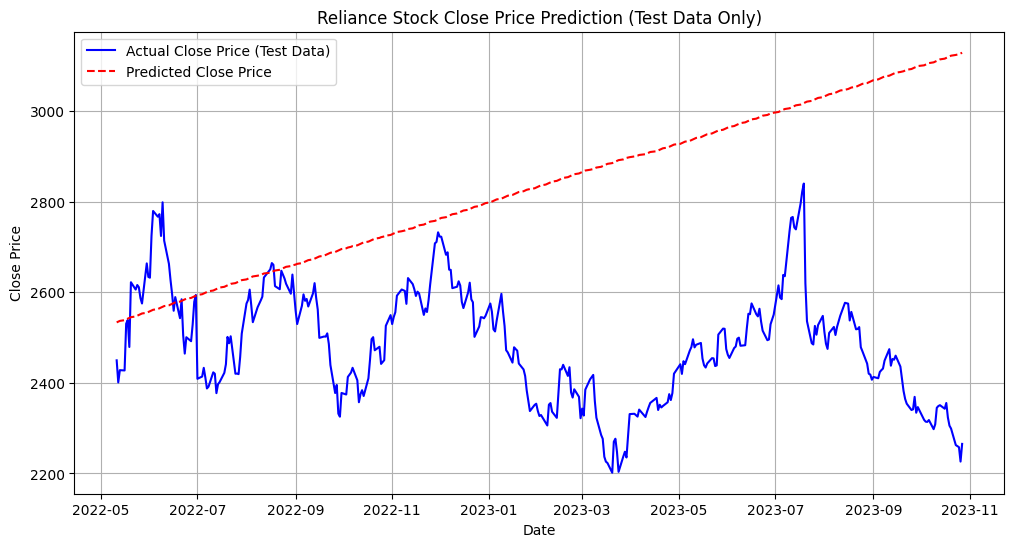

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(test_original,'b',label='Actual prices')
# plt.plot(pred_data, 'orange',label='Predicted prices')
plt.plot(df.index[-test_days:], y_test, label='Actual Close Price (Test Data)', color='blue')
plt.plot(df.index[-test_days:], y_pred_reg, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Reliance Stock Close Price Prediction (Test Data Only)')
plt.legend()
plt.grid(True)
plt.show()




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1077
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5275.195
Date:                Fri, 08 Nov 2024   AIC                          10552.390
Time:                        19:10:07   BIC                          10557.371
Sample:                             0   HQIC                         10554.276
                               - 1077                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1061.3738     26.590     39.916      0.000    1009.258    1113.490
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):               692.66
Prob(Q):                              0.32   Pr

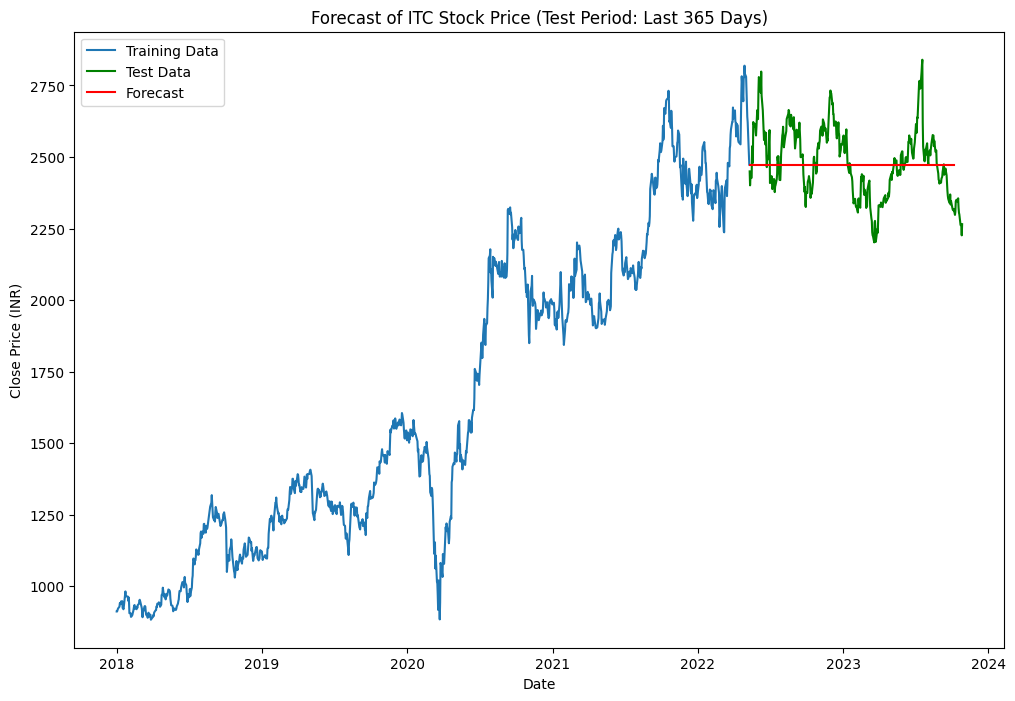

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the CSV file from Google Drive (adjust path as needed)
data = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")

# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Focus on the 'Close Price' for time series forecasting
close_prices = data['Close']

# Split the data into training and testing sets (last 365 days as test)
train_data = close_prices[:-365]
test_data = close_prices[-365:]

# Fit the ARIMA model on the training data (adjust order based on ACF and PACF plots if necessary)
model = ARIMA(train_data, order=(0, 1, 0))
results = model.fit()

# Print the model summary
print(results.summary())

# Forecast the next 365 days (same length as test data)
forecast = results.get_forecast(steps=515)
forecast_index = pd.date_range(start=train_data.index[-1], periods=516, freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plotting the forecast alongside the actual test data
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_series, label='Forecast', color='red')

plt.title('Forecast of ITC Stock Price (Test Period: Last 365 Days)')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.show()


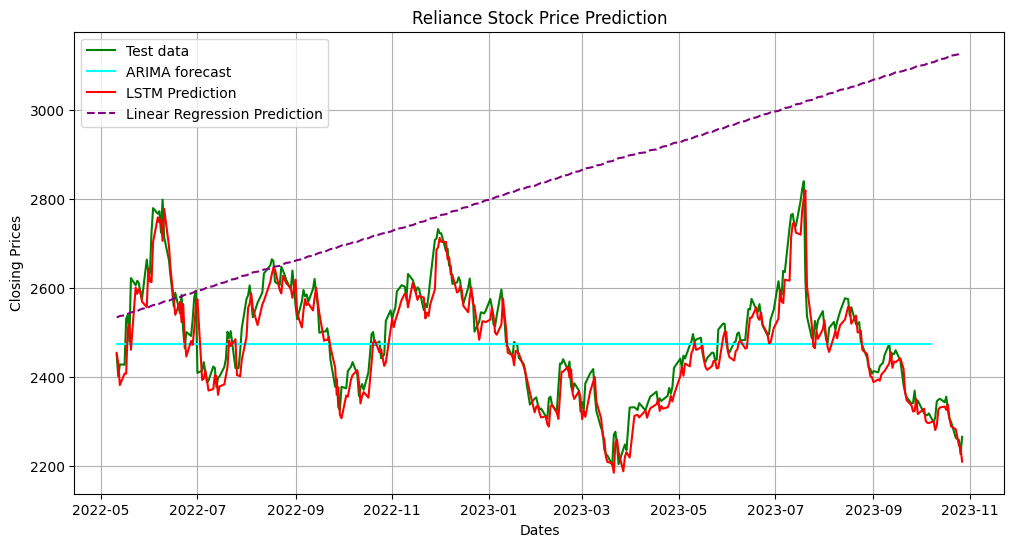

In [ ]:


plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original, 'g', label='Test data')
plt.plot(forecast_series, label='ARIMA forecast', color='cyan')
# plt.plot(train_original, 'b', label='Train data')

plt.plot(pred_data, 'red', label='LSTM Prediction')
plt.plot(df.index[-test_days:], y_pred_reg, label='Linear Regression Prediction', color='Purple', linestyle='--')

plt.title(company + ' Stock Price Prediction')
plt.legend()

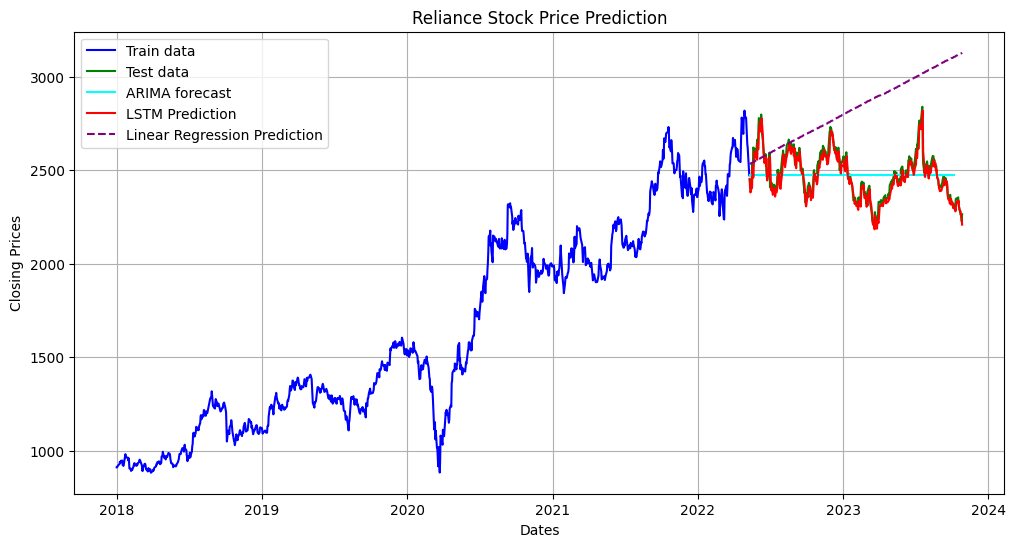

In [ ]:


plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(forecast_series, label='ARIMA forecast', color='cyan')
plt.plot(pred_data, 'red', label='LSTM Prediction')
plt.plot(df.index[-test_days:], y_pred_reg, label='Linear Regression Prediction', color='Purple', linestyle='--')

plt.title(company + ' Stock Price Prediction')
plt.legend()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df= pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is the DataFrame with 'Date' and 'Close' columns
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 1: Calculate the RSI
window_length = 14

# Calculate price differences
delta = df['Close'].diff()

# Separate positive and negative gains
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()

# Calculate the Relative Strength (RS) and RSI
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Step 2: Identify Buy and Sell signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20
sell_signals = (RSI > 80)  # Sell when RSI is above 80

# Step 3: Plot the close price and RSI with buy/sell signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

# Set yellow background for both subplots
# fig.patch.set_facecolor('yellow')

# Plot the Close Price in the first subplot
ax1.plot(df['Date'], df['Close'], color='blue', label='Close Price')
ax1.set_title('Reliance Stock Close Price')
ax1.set_ylabel('Close Price')
ax1.grid(True, color='white')  # Grid lines in white for contrast

# Plot Buy and Sell signals
ax1.plot(df['Date'][buy_signals], df['Close'][buy_signals],
         '^', markersize=10, color='green', label='Buy Signal')  # Buy signal in green
ax1.plot(df['Date'][sell_signals], df['Close'][sell_signals],
         'v', markersize=10, color='red', label='Sell Signal')  # Sell signal in red

# Plot the RSI in the second subplot
ax2.plot(df['Date'], RSI, color='purple', label='RSI (14)')  # RSI in cyan
ax2.set_title('Relative Strength Index (RSI) - 14 Day')
ax2.set_ylabel('RSI')
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought (80)')  # Overbought line in red
ax2.axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold (20)')  # Oversold line in green
ax2.grid(True, color='white')  # Grid lines in white for contrast

# Format x-axis to show only the year labels on the bottom subplot
ax2.xaxis.set_major_locator(mdates.YearLocator())  # Show ticks at the start of each year
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.setp(ax2.get_xticklabels(), rotation=45)  # Rotate for readability

# Ensure date labels are only on the bottom subplot
ax1.tick_params(axis='x', labelbottom=False)

# Custom legend for signals on the right corner
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', fontsize=10)
handles_rsi, labels_rsi = ax2.get_legend_handles_labels()
ax2.legend(handles_rsi, labels_rsi, loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


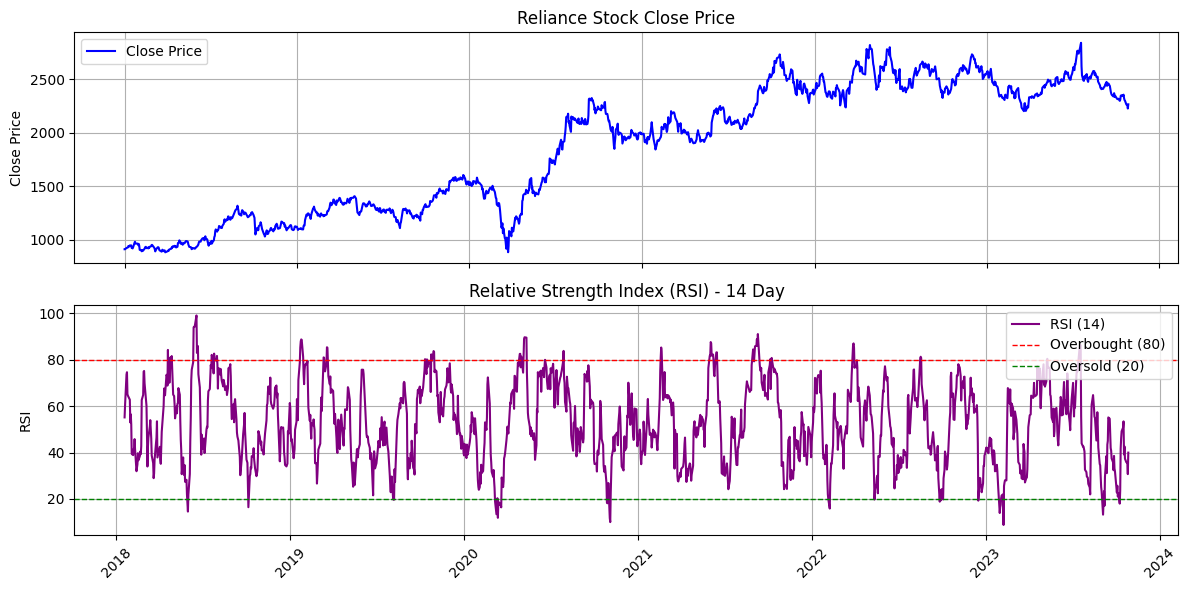

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data and ensure 'Date' is in datetime format
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the RSI
window_length = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Plot close price and RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

# Plot the Close Price
ax1.plot(df['Date'], df['Close'], color='blue', label='Close Price')
ax1.set_title('Reliance Stock Close Price')
ax1.set_ylabel('Close Price')
ax1.grid(True)

# Plot the RSI
ax2.plot(df['Date'], RSI, color='purple', label='RSI (14)')
ax2.set_title('Relative Strength Index (RSI) - 14 Day')
ax2.set_ylabel('RSI')
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought (80)')
ax2.axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold (20)')
ax2.grid(True)

# Format x-axis and legends
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax2.get_xticklabels(), rotation=45)
ax1.tick_params(axis='x', labelbottom=False)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


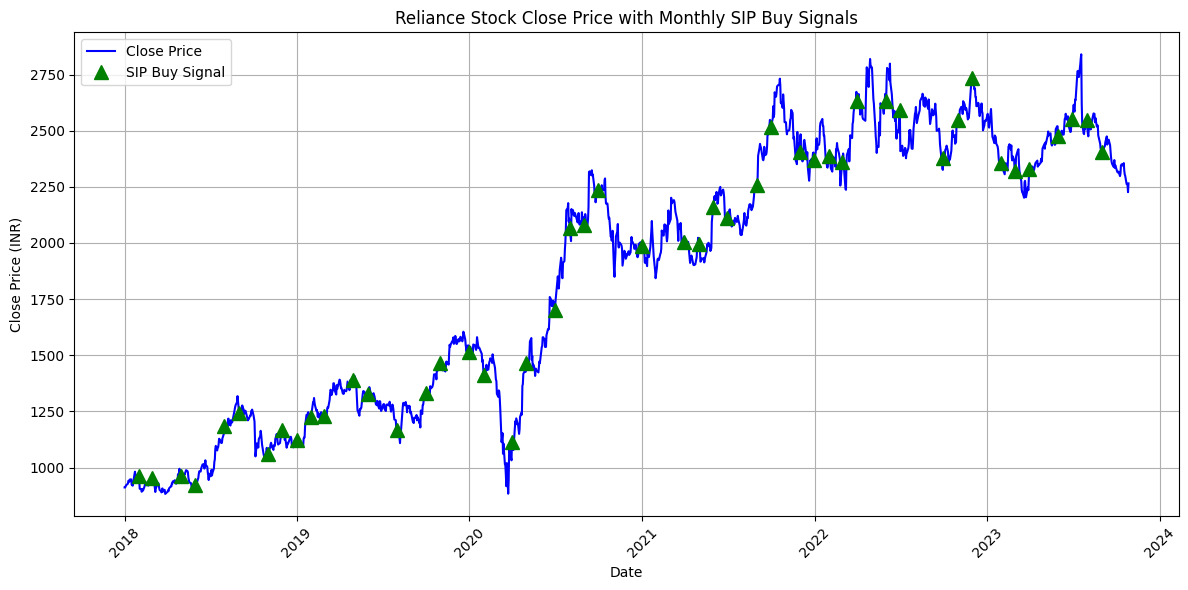

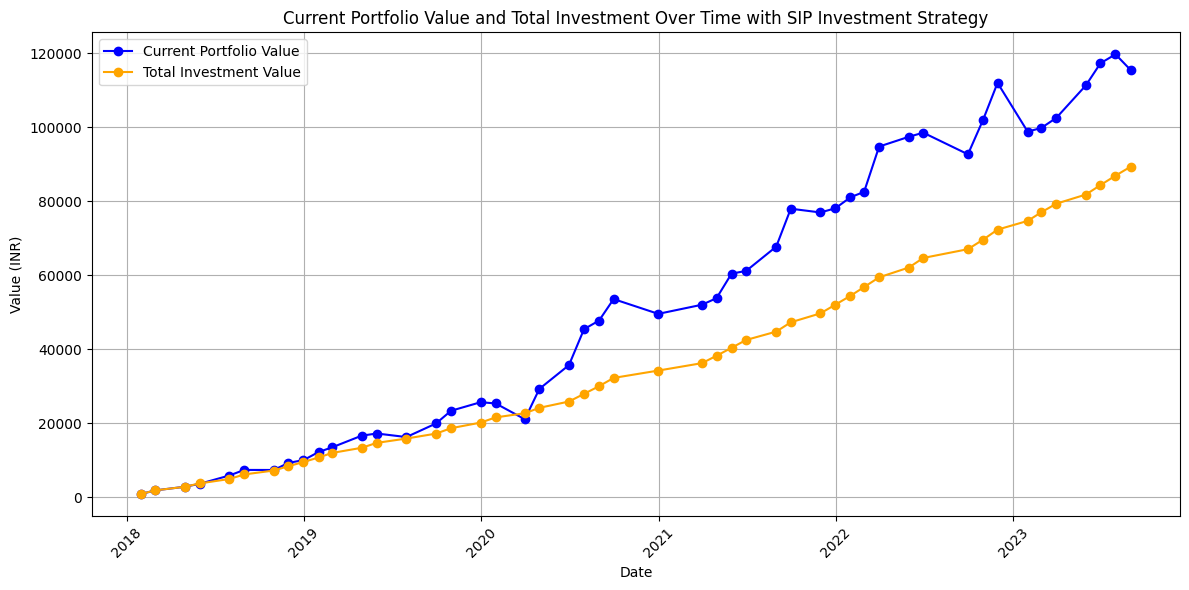

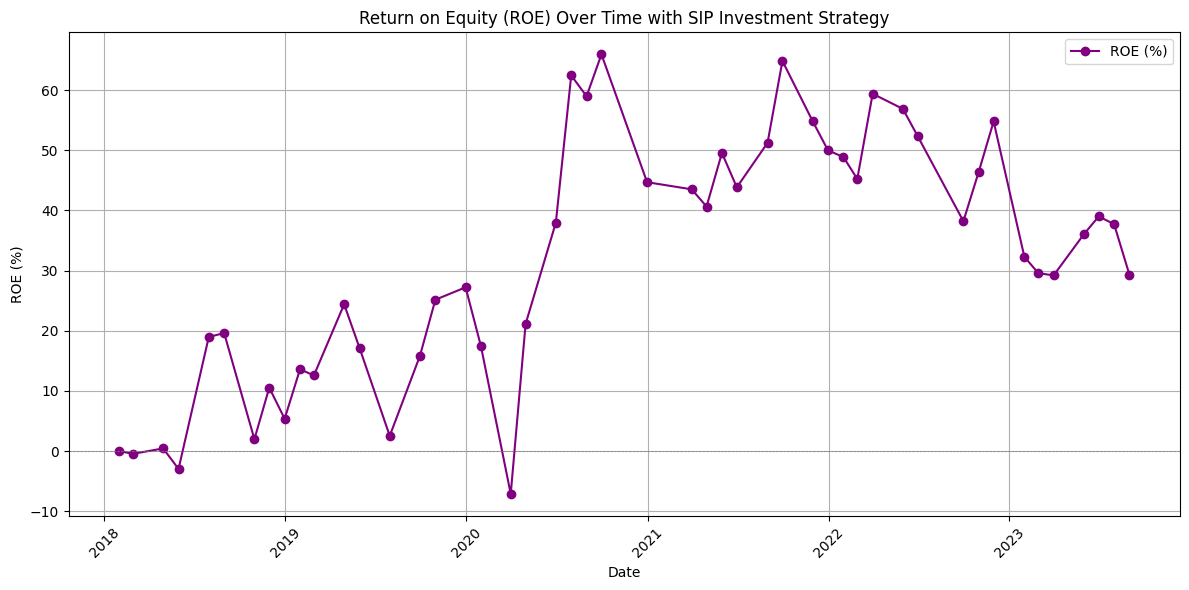

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")

# Ensure 'Date' column is in datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# SIP Investment Strategy Variables
total_investment = 0     # Total investment
shares_owned = 0         # Total shares owned
investment_records = []  # To store each month's investment record
buy_dates = []           # To store the dates when SIP buys are made

# Loop through the DataFrame to identify monthly investments
for index, row in df.iterrows():
    # Check if the row corresponds to the end of the month
    if row['Date'].is_month_end:  # This checks if the date is the last day of the month
        # Buy 1 share
        price = row['Close']
        shares_owned += 1
        total_investment += price  # Increase total investment by the price of the stock

        # Current portfolio value at this moment
        current_value = shares_owned * row['Close']  # Current value of the portfolio
        roe = (current_value - total_investment) / total_investment * 100  # ROE calculation

        # Record the investment details
        investment_records.append({
            'Date': row['Date'],
            'Investment Price': price,
            'Total Investment': total_investment,
            'Current Portfolio Value': current_value,
            'ROE (%)': roe
        })

        # Record the date for SIP buy signal
        buy_dates.append(row['Date'])

# Convert records to DataFrame for better visualization
investment_df = pd.DataFrame(investment_records)

# Plotting Close Price with SIP Buy Signals
plt.figure(figsize=(12, 6))

# Plotting the Close Price of the stock
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')

# Adding SIP Buy Signals on Close Price Plot
plt.plot(df[df['Date'].isin(buy_dates)]['Date'],
         df[df['Date'].isin(buy_dates)]['Close'],
         '^', markersize=10, color='green', label='SIP Buy Signal')  # Green triangle for SIP buys

plt.title('Reliance Stock Close Price with Monthly SIP Buy Signals')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plotting Current Portfolio Value and Total Investment
plt.figure(figsize=(12, 6))
plt.plot(investment_df['Date'], investment_df['Current Portfolio Value'], marker='o', label='Current Portfolio Value', color='blue')
plt.plot(investment_df['Date'], investment_df['Total Investment'], marker='o', label='Total Investment Value', color='orange')

plt.title('Current Portfolio Value and Total Investment Over Time with SIP Investment Strategy')
plt.xlabel('Date')
plt.ylabel('Value (INR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plotting ROE on a separate graph
plt.figure(figsize=(12, 6))
plt.plot(investment_df['Date'], investment_df['ROE (%)'], marker='o', color='purple', label='ROE (%)')

plt.title('Return on Equity (ROE) Over Time with SIP Investment Strategy')
plt.xlabel('Date')
plt.ylabel('ROE (%)')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add horizontal line at 0%
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


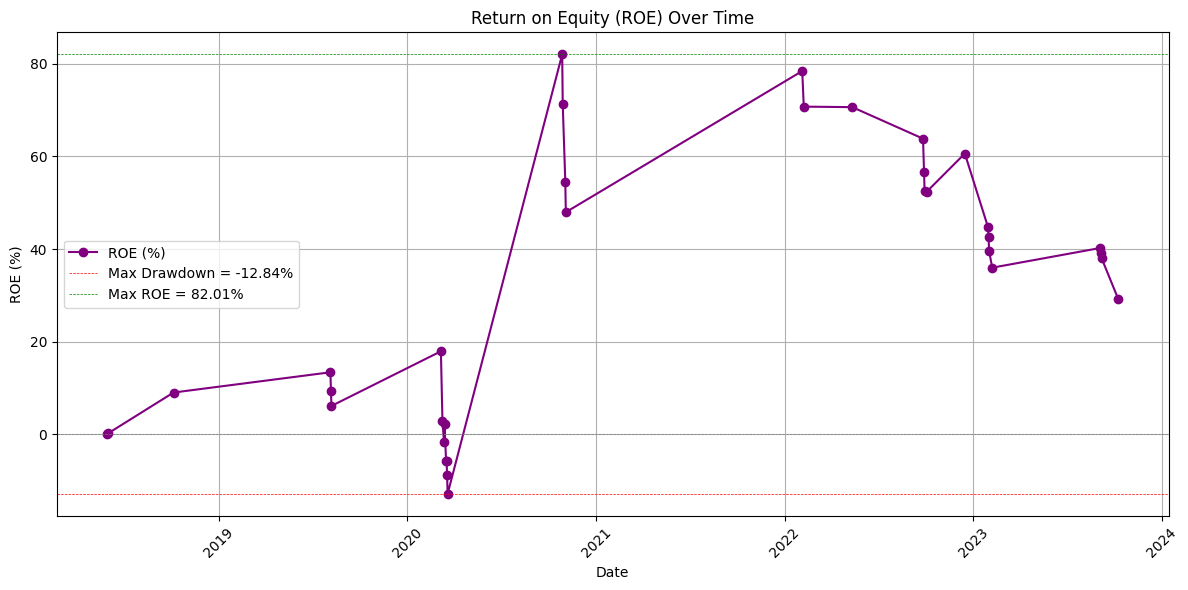

Maximum Drawdown: -12.84%
Maximum ROE: 82.01%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/MTP/Reliance.csv")

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the RSI
window_length = 14
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=window_length).mean()
loss = -delta.where(delta < 0, 0).rolling(window=window_length).mean()
RS = gain / loss
RSI = 100 - (100 / (1 + RS))

# Identify Buy signals
buy_signals = (RSI < 20)  # Buy when RSI is below 20

# Variables to track investment over time
total_invested = 0
total_shares = 0  # Total shares accumulated
roe_values = []  # To store ROE values over time
dates = []       # To store dates corresponding to ROE values

# Track investment over time
for i in range(len(df)):
    # Buy signal
    if buy_signals[i]:
        # Current price at the buy signal
        current_price = df['Close'][i]

        # Update the total shares and invested amount
        total_shares += 1  # Since we are buying one share at each signal
        total_invested += current_price  # Update total invested amount

        # Calculate the current portfolio value
        current_portfolio_value = total_shares * df['Close'][i]
        # Calculate ROE
        roe = ((current_portfolio_value - total_invested) / total_invested) * 100 if total_invested > 0 else 0

        # Append the ROE and corresponding date
        roe_values.append(roe)
        dates.append(df['Date'][i])

# Calculate maximum drawdown and maximum ROE
max_drawdown = min(roe_values) if roe_values else 0
max_roe = max(roe_values) if roe_values else 0

# Plot ROE values over time
plt.figure(figsize=(12, 6))
plt.plot(dates, roe_values, marker='o', color='purple', label='ROE (%)')
plt.title('Return on Equity (ROE) Over Time')
plt.xlabel('Date')
plt.ylabel('ROE (%)')
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add horizontal line at 0%
plt.axhline(max_drawdown, color='red', linewidth=0.5, linestyle='--', label=f'Max Drawdown = {max_drawdown:.2f}%')  # Max drawdown line
plt.axhline(max_roe, color='green', linewidth=0.5, linestyle='--', label=f'Max ROE = {max_roe:.2f}%')  # Max ROE line
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Maximum ROE: {max_roe:.2f}%")
